## L2 norm estimation of the equivalent layer parameters

This notebook evaluates the predicted data obtained by an equivalent layer located at a specific depth.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from coord import GGS
from normal_grav import Norm_Grav
from equiv_layer import EqLayer
from carto_map_plot import point_map
from carto_map_plot import grid_map
import config_style_plot as style

# Redefining functions
geodetic2cartesian = GGS().geodetic2cartesian
rotation_matrix = GGS().rotation_matrix
closedform = Norm_Grav().closedform
# Plot style
style.plot_params()

In [2]:
def L1_estim(rcl, pcl, Acc_l, it_max):
    for i in range(it_max):
#         print i
        res = rcl - np.dot(Acc_l, pcl)
        W = np.dot(Acc_l.T, np.diag(1./(np.abs(res)+1e-10)) )
        pcl = np.linalg.solve(np.dot(W, Acc_l), np.dot(W, rcl))
    return pcl

In [3]:
# IMPORTING EIGEN FILE
header=['LONG', 'LAT', 'GRAV']
path = '../data/ICGEM/EIGEN_'
uf = 'RJ'
name_bdg = '.gdf'
eigen = pd.read_csv('{p}{u}{ne}'.format(p=path,u=uf,ne=name_bdg), sep='\s+',names=header, skiprows=34)
# bdg
alt = np.zeros_like(eigen.LONG.values) + 3000.
gamma = closedform(alt, eigen.LAT.values)

In [4]:
# Obtaining short wavelength signals
disturb = eigen.GRAV.values - gamma

data = {'LONG':eigen.LONG.values-360., \
        'LAT':eigen.LAT.values, \
        'ALT':alt, \
        'GRAV':eigen.GRAV.values, \
        'GAMMA':gamma, \
        'DIST':disturb}
df = pd.DataFrame(data)
df

,LONG,LAT,ALT,GRAV,GAMMA,DIST
0,-45.00,-20.5,3000.0,977758.054217,977740.578178,17.476039
1,-44.95,-20.5,3000.0,977761.488358,977740.578178,20.910180
2,-44.90,-20.5,3000.0,977762.622728,977740.578178,22.044550
3,-44.85,-20.5,3000.0,977763.816592,977740.578178,23.238414
4,-44.80,-20.5,3000.0,977769.058146,977740.578178,28.479968
...,...,...,...,...,...,...
6456,-40.70,-24.0,3000.0,977926.009356,977961.840770,-35.831414
6457,-40.65,-24.0,3000.0,977926.478857,977961.840770,-35.361913
6458,-40.60,-24.0,3000.0,977927.060801,977961.840770,-34.779968
6459,-40.55,-24.0,3000.0,977927.252963,977961.840770,-34.587807


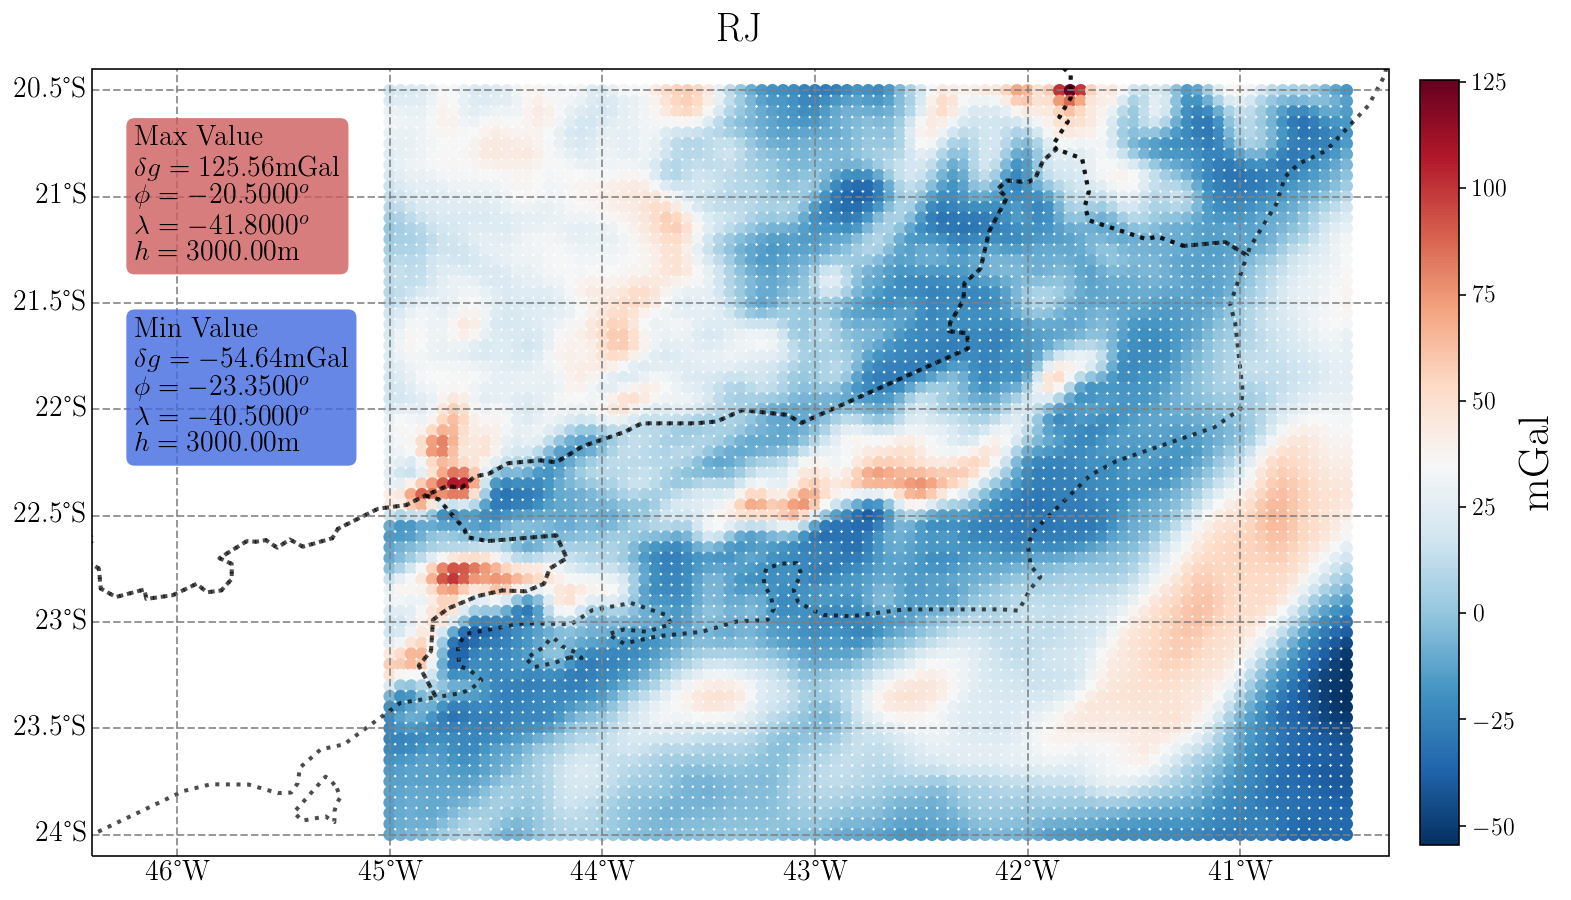

In [5]:
point_map(df.LONG, df.LAT, df.ALT, df.DIST, uf, fig_size=(14.,16.), region=[-46.4,-40.3,-24.1,-20.4], \
         sign=(-46.2,-46.2,-21.3,-22.2), shrink=0.44)#, lim_val=(True, 40.))

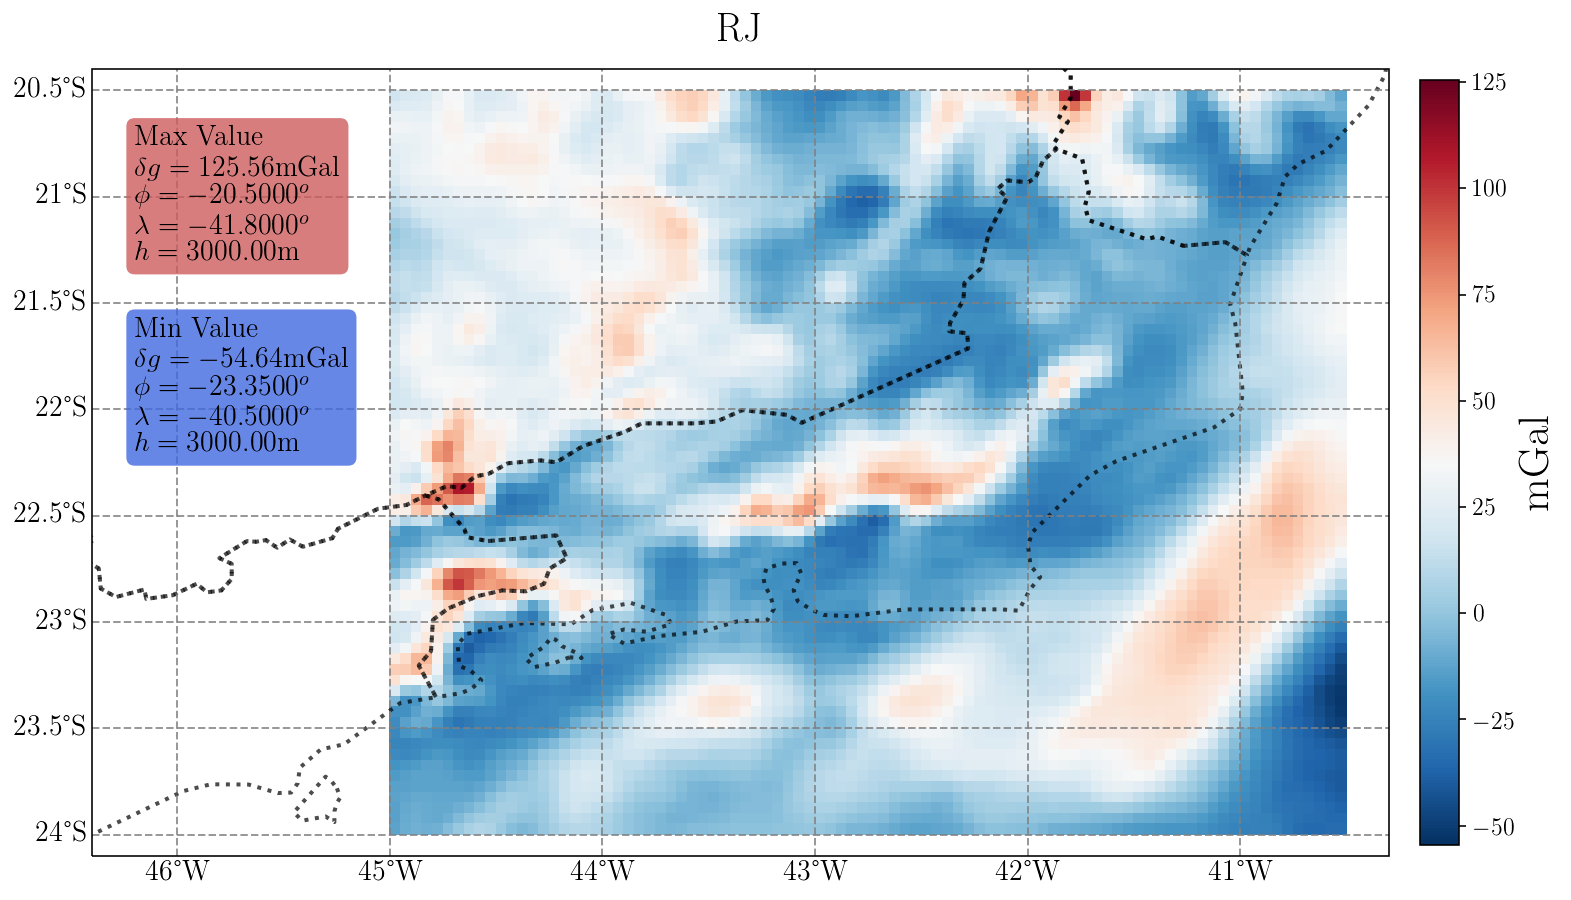

In [6]:
grid_map(df.LONG, df.LAT, df.ALT, df.DIST, uf, fig_size=(14.,16.), region=[-46.4,-40.3,-24.1,-20.4], \
         sign=(-46.2,-46.2,-21.3,-22.2), shrink=0.44)#, lim_val=(True, 40.))

### Calculating rotation matrices and Cartesian coordinates

In [7]:
# Calculating Cartesian coordinates
x, y, z = geodetic2cartesian(df.LONG, df.LAT, df.ALT)
R = np.array(rotation_matrix(df.LONG, df.LAT))

## Estimating the first set of point-mass parameters

In [8]:
pc = []
hc = []
indc = []
xc = []
yc = []
zc = []
Rc = []
rabs_max = []
taur = 1e-11 #1e-5 #0.05
tauc = 1e-3
it_max_l1 = 5
latc = []
lonc = []

## Iteração 1 - L2 norm

In [9]:
indl = np.arange(disturb.size)
# mi_c = 1e-5
mi_c = 1e-30
hcl = 3000. #5000. #14200. # 20000. #800. #1000.
print(hcl, type(indl)) #indl

3000.0 <class 'numpy.ndarray'>


In [10]:
rcl = disturb[indl]
xcl = x[indl]
ycl = y[indl]
zcl = z[indl]

latcl = df.LAT[indl]
loncl = df.LONG[indl]

In [11]:
Rcl = R[:, indl]

In [12]:
# Calculo de Acc_l
hlay = np.zeros(indl.size) - hcl
xlay, ylay, zlay = geodetic2cartesian(loncl, latcl, hlay)
Lay = EqLayer(df.LONG, df.LAT, np.zeros_like(df.LONG)-hcl)
layer = Lay.build_layer(xlay, ylay, zlay)
Acc_l = Lay.designMat(xcl, ycl, zcl, Rcl, layer)
print(Acc_l.shape)

(6461, 6461)


In [13]:
H = np.dot(Acc_l.T, Acc_l)
# H += mi_c*np.trace(H)*np.identity(indl.size)
H += (mi_c*np.trace(H)*np.identity(indl.size))/indl.size

In [14]:
p_L2 = np.linalg.solve(H, np.dot(Acc_l.T, rcl))
print(p_L2.size)
# p_L1 = L1_estim(rcl, p_L2, Acc_l, 5)

6461


In [15]:
rcl -= np.dot(Acc_l, p_L2)
# print rcl[:50]

In [16]:
rabs_max_l = np.max(np.abs(rcl))
rabs_max_l

4.767741756950272e-12

In [17]:
pc.append(p_L2)
hc.append(hcl)
indc.append(indl)
xc.append(xcl)
yc.append(ycl)
zc.append(zcl)
Rc.append(Rcl)
latc.append(latcl)
lonc.append(loncl)

In [18]:
rabs_max.append(rabs_max_l)

In [19]:
rc = rcl[:] #r1
print(np.max(np.abs(rc)))

4.767741756950272e-12


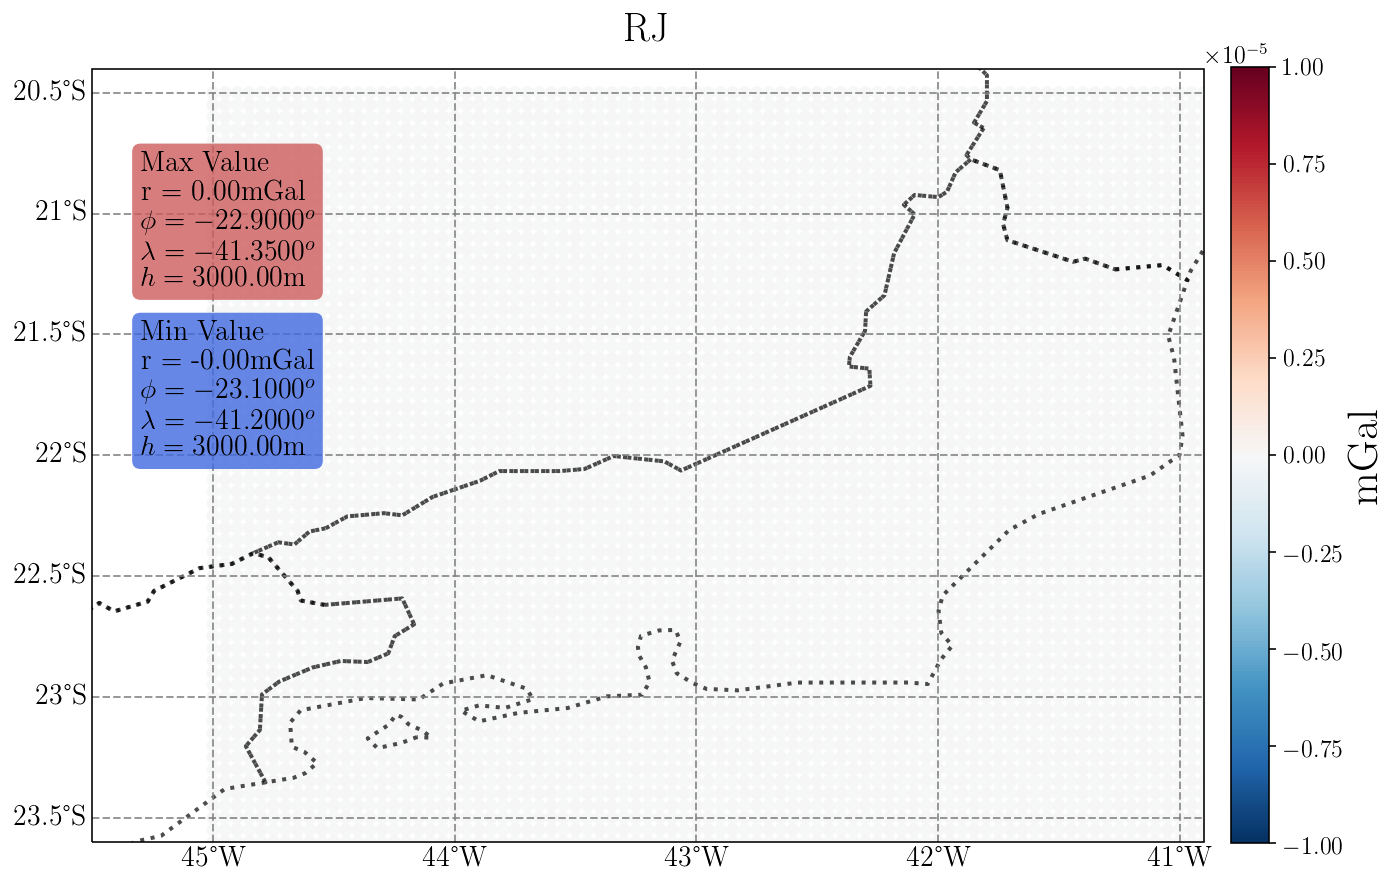

In [20]:
point_map(df.LONG, df.LAT, df.ALT, rc, uf, fig_size=(12.,14.), region=[-45.5,-40.9,-23.6,-20.4], \
         sign=(-45.3,-45.3,-21.3,-22), residual=True, lim_val=(True, 1e-5))

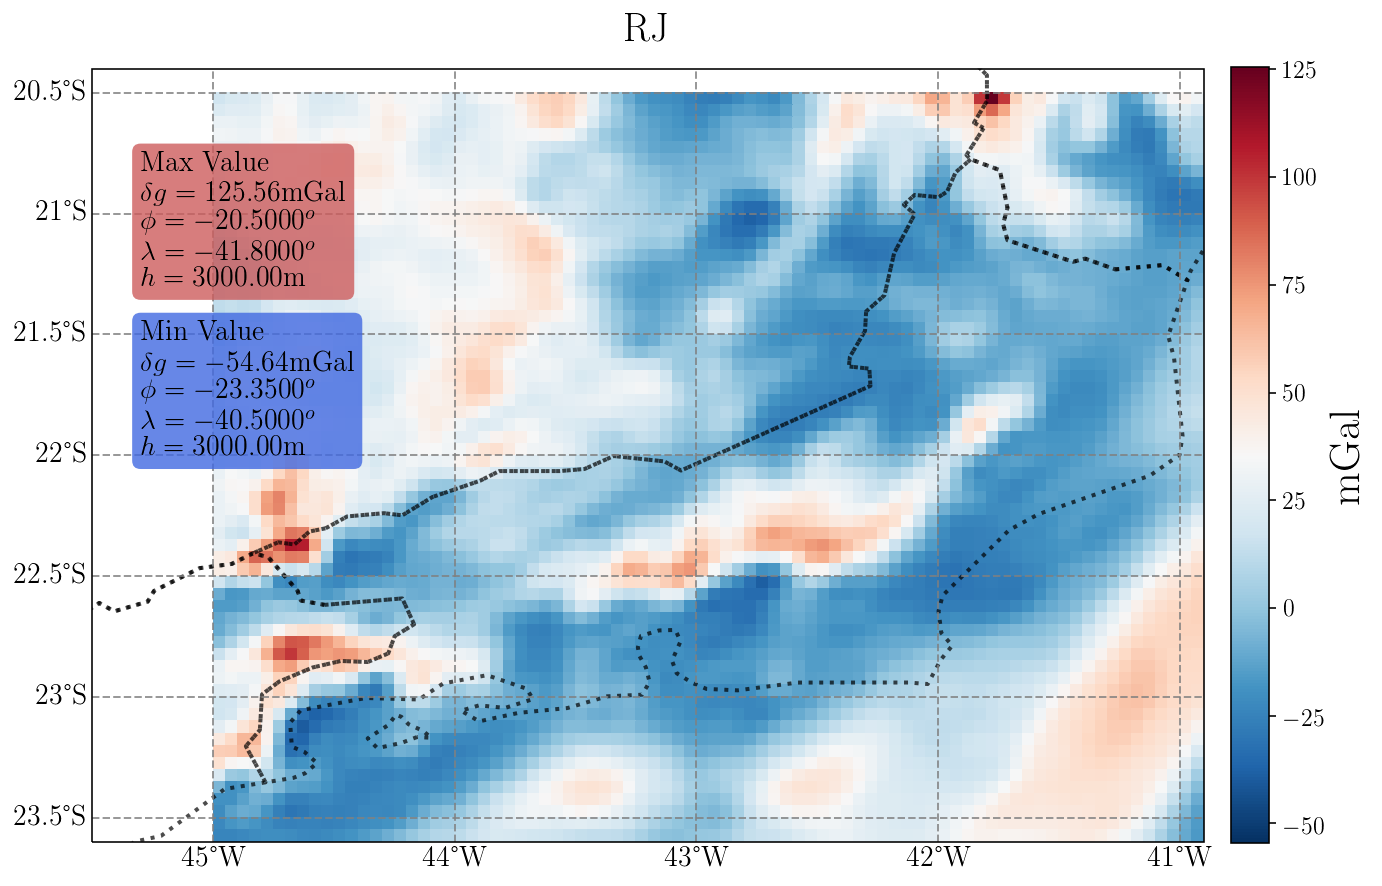

In [21]:
grid_map(df.LONG, df.LAT, df.ALT, df.DIST, uf, fig_size=(12.,14.), region=[-45.5,-40.9,-23.6,-20.4], \
         sign=(-45.3,-45.3,-21.3,-22))#, lim_val=(True, 40.))

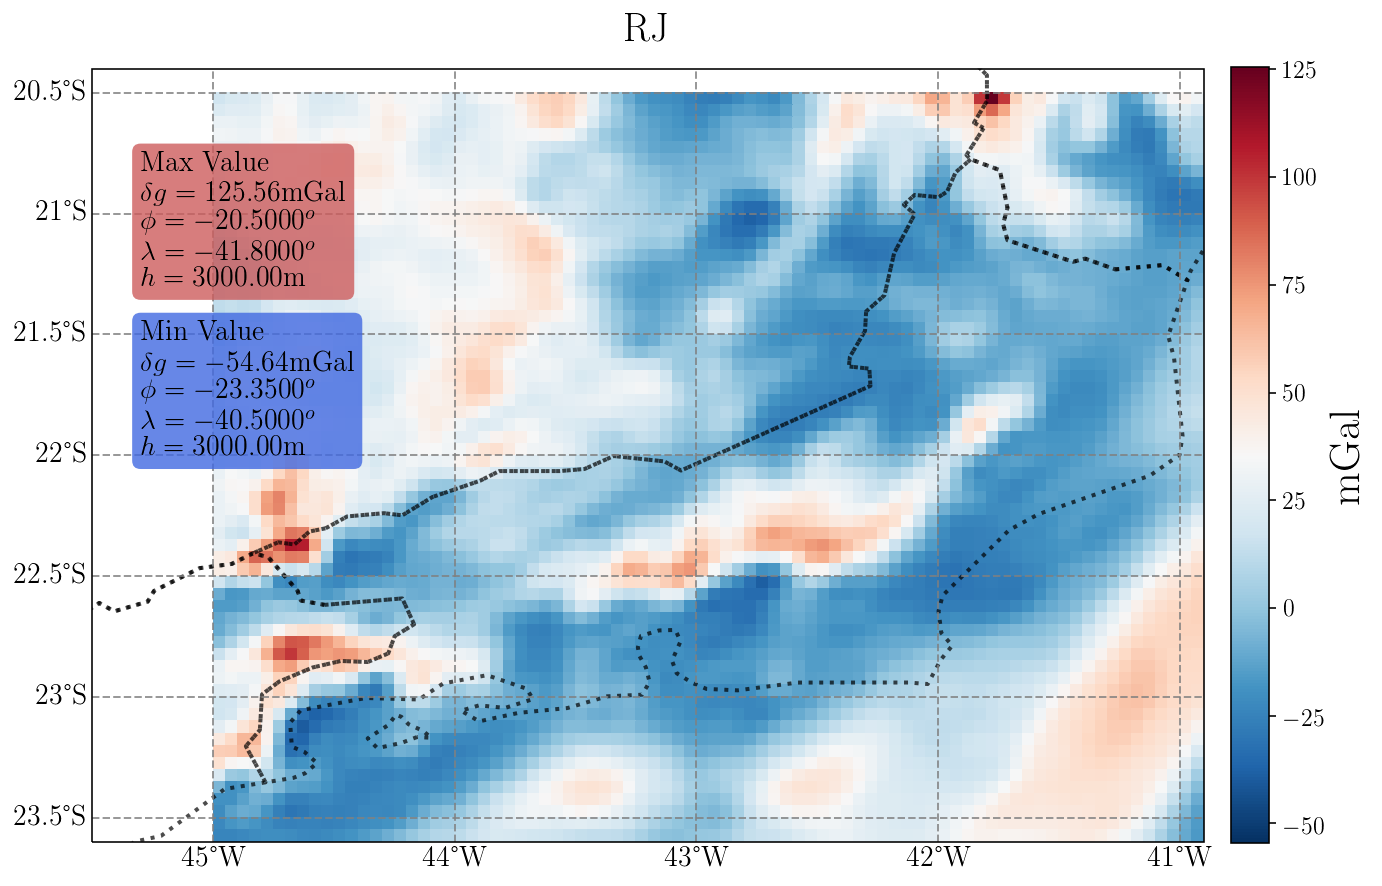

In [22]:
grid_map(df.LONG, df.LAT, df.ALT, np.dot(Acc_l, p_L2), uf, fig_size=(12.,14.), \
          region=[-45.5,-40.9,-23.6,-20.4], sign=(-45.3,-45.3,-21.3,-22))#, lim_val=(True, 40.))

In [23]:
print(len([value for value in rc if value > 1e-5]))
print([value for value in rc if value > 1e-5])

0
[]


In [24]:
new_data = {'LONG':eigen.LONG.values-360., \
        'LAT':eigen.LAT.values, \
        'ALT':alt, \
        'GRAV':eigen.GRAV.values, \
        'GAMMA':gamma, \
        'DIST':disturb, \
        'RHO':p_L2, \
        'RESID':rc}
df = pd.DataFrame(new_data)
df

,LONG,LAT,ALT,GRAV,GAMMA,DIST,RHO,RESID
0,-45.00,-20.5,3000.0,977758.054217,977740.578178,17.476039,7.155741e+12,2.486900e-14
1,-44.95,-20.5,3000.0,977761.488358,977740.578178,20.910180,7.056270e+12,3.694822e-13
2,-44.90,-20.5,3000.0,977762.622728,977740.578178,22.044550,7.496298e+12,-1.634248e-13
3,-44.85,-20.5,3000.0,977763.816592,977740.578178,23.238414,6.065271e+12,-1.385558e-13
4,-44.80,-20.5,3000.0,977769.058146,977740.578178,28.479968,9.579322e+12,-2.842171e-13
...,...,...,...,...,...,...,...,...
6456,-40.70,-24.0,3000.0,977926.009356,977961.840770,-35.831414,-1.456624e+13,7.531753e-13
6457,-40.65,-24.0,3000.0,977926.478857,977961.840770,-35.361913,-1.359730e+13,-1.563194e-12
6458,-40.60,-24.0,3000.0,977927.060801,977961.840770,-34.779968,-1.414087e+13,5.471179e-13
6459,-40.55,-24.0,3000.0,977927.252963,977961.840770,-34.587807,-1.093470e+13,2.273737e-13


In [25]:
print(df.RESID.min(), df.RESID.max())

-3.943512183468556e-12 4.767741756950272e-12
